# Prediction of being at risk of having CardioVascular Disease


Citation:
1.	License:	Unknown
2.	Domain:	Public
3.	Dataset owner:	Svetlana Ulianova
4.	Date created:	2019-01-20

Features:
1.	Age | Objective Feature | age | int (days)
2.	Height | Objective Feature | height | int (cm) |
3.	Weight | Objective Feature | weight | float (kg) |
4.	Gender | Objective Feature | gender | categorical code |
5.	Systolic blood pressure | Examination Feature | ap_hi | int |
6.	Diastolic blood pressure | Examination Feature | ap_lo | int |
7.	Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8.	Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9.	Smoking | Subjective Feature | smoke | binary |
10.	Alcohol intake | Subjective Feature | alco | binary |
11.	Physical activity | Subjective Feature | active | binary |
12.	Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# Loading the data
df = pd.read_csv('cardio_train.csv', sep=';', usecols=range(1,13))

In [3]:
# Viewing the first 5 rows of data
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [4]:
# Getting to know the shape, therefore size of our data
df.shape

(69301, 12)

In [5]:
# Checking for types of values in particular columns
df.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [6]:
# Looking for any empty places in data
df.isnull().values.any()

False

In [7]:
# Getting rough statistical description of the whole data
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


- It seems like age is viable in terms of range -> 10798 days to 23713 days, approx 30 to 65 years old. Convert to years
- Gender is mapped either to 1 or 2, it needs further examination to judge which digit means male/female
- Height would need examination since min. value 55cm is suspiciously close to the shortest known human
- Weight needs to be checked also, 10kg is possible though suspicious
- Both pressures minimal values seem to bo mistakenly negative and maximum value is way to high
- Rest of the data seems fine

# Age

Converting age to years

In [8]:
df['age'] = df['age'].apply(lambda x: x/365.25)

# Gender

Looking for a correlation making it possible to assign number to a particular sex

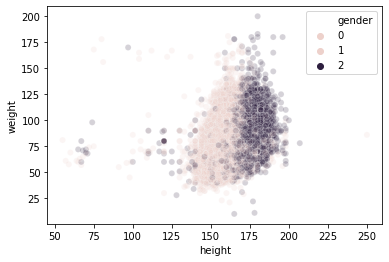

In [9]:
sns.scatterplot(x=df['height'], y=df['weight'], hue=df['gender'], alpha=0.2)
plt.show()

In [10]:
df[df['gender']==0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


gender 0 from the legend must be some mistake in seaborn

Above plot makes it possible to conclude that, being minimally finer, women are presented as "1".<br>
To be sure lets confirm this, plotting the distribution of weight and height for particular groups.

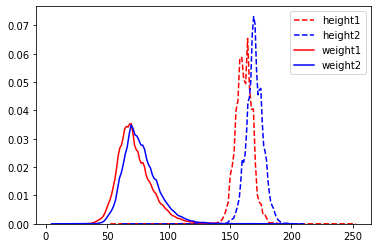

In [11]:
import warnings
warnings.filterwarnings('ignore')
sns.kdeplot(df['height'][df['gender']==1], label='height1', c='r', linestyle='--')
sns.kdeplot(df['height'][df['gender']==2], label='height2', c='b', linestyle='--')
sns.kdeplot(df['weight'][df['gender']==1], label='weight1', c='r')
sns.kdeplot(df['weight'][df['gender']==2], label='weight2', c='b')
plt.show()

It seems that men are indeed represented by the blue color and therefore by digit 2.<br>

Renaming the column from "gender" to bool-type "male", simultaneously mapping right values.

In [12]:
df['gender'] = df['gender'].map({1:0, 2:1})
df.rename(columns={'gender': 'male'}, inplace=True)

# Pressure

Exploring suspicious pressure values

In [13]:
df[df['ap_hi'] > 800]

,age,male,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1177,41.385352,0,160,60.0,902,60,1,1,0,0,1,0
1315,62.182067,1,167,59.0,906,0,1,1,0,0,1,0
4118,39.493498,0,168,63.0,909,60,2,1,0,0,1,0
7064,57.582478,0,175,80.0,11500,90,1,1,0,0,1,1
8216,51.663244,0,164,75.0,1420,80,2,1,0,0,1,1
13196,43.794661,0,168,72.0,1500,80,1,1,0,0,1,1
17014,61.322382,1,163,50.0,907,70,3,3,0,0,1,1
23168,44.164271,0,161,92.0,906,0,2,1,0,0,1,1
24765,43.353867,1,169,75.0,14020,80,2,1,0,0,1,1
24820,58.483231,0,169,71.0,14020,80,3,3,0,0,1,1


As the ap_hi pressure above 180mmHg is extremely dangerous, we will allow readings up to 180 +10%.<br>
As for the lower bound we will take 50, since we do not know the circumstances in which patients were during tests.<br>
From the literature, we can learn that pressure measuring equipment can detect max 300mmHg.<br>
Source: https://www.ncbi.nlm.nih.gov/books/NBK279251/<br>
We will therefore reject readings above 198mmHg. As of the readings higher than 800mmHg it is possible,<br>
that these readings' decimal point has been ommited. We will divide by 10 all readings ranging from 800 to 999<br>
and by 100 readings above 1000mmHg but also 10000mmHg and further.<br>
Therefore all numbers >1000 could be divided in such way that they result as hundreds.<br>
This thesis require that there are no values present between 2000 and 8000,<br>
since it would imply improbable pressure below 80mmHg.

In [14]:
# Getting the absolute value of all readings to eliminate possible typos
df['ap_hi'] = df['ap_hi'].apply(abs)
df['ap_lo'] = df['ap_lo'].apply(abs)

In [15]:
df[(df['ap_hi'] > 2000) & (df['ap_hi'] < 8000)]

,age,male,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


As we can see, we are good to go:

In [16]:
df['ap_hi'] = df['ap_hi'].apply(lambda x: x/10 if (x>800 and len(str(x))==3) else (x/(10**(len(str(x))-3)) if len(str(x))>3 else x))

In [17]:
# Dropping rows with Systolic blood pressure between 198 and 800
df.drop(df[(df['ap_hi']>198) & (df['ap_hi']<800)].index, inplace=True)

In [18]:
# Dropping rows with Systolic blood pressure below 50mmHg
df.drop(df[df['ap_hi']<50].index, inplace=True)

We will perform similar operations for diastolic pressure, allowing it to be between 50 and 132.

In [19]:
df['ap_lo'] = df['ap_lo'].apply(lambda x: x/10 if (x>800 and x<1320) else (x/100 if x>=8000 else x))

In [20]:
df.drop(df[(df['ap_lo']>132) | (df['ap_lo']<50)].index, inplace=True)

Now we will check how the boxplots look with possible, but necessary to allow outliers.

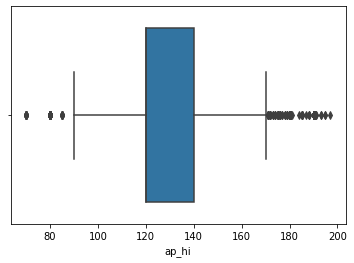

In [21]:
sns.boxplot(x='ap_hi', data=df)

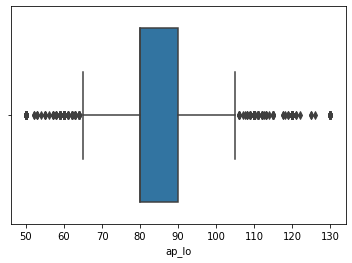

In [22]:
sns.boxplot(x='ap_lo', data=df)

# Height and weight

Next step is to eliminate impossible outliers for height and weight.

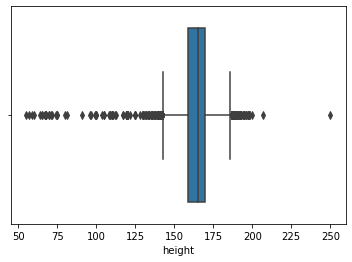

In [23]:
sns.boxplot(x='height', data=df)

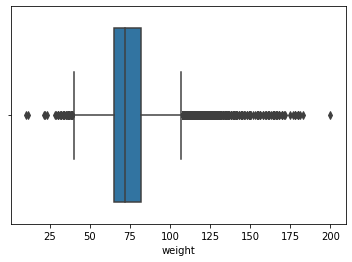

In [24]:
sns.boxplot(x='weight', data=df)

Extreme values for both weight and height do not only seem impossible but also are an outliers.<br>
Therefore we will check whether the 1% quantile is common to probable measures and if rejecting it<br>
will help us get rid of outliers.

In [25]:
print('Lightest 1%: ',df.weight.quantile(0.01))
print('Heaviest 1%: ',df.weight.quantile(0.99))
print('Shortest 1%: ',df.height.quantile(0.01))
print('Tallest 1%: ',df.height.quantile(0.99))

Lightest 1%:  48.0
Heaviest 1%:  117.0
Shortest 1%:  147.0
Tallest 1%:  184.0


Since weight above 117kg is far more probable and more common in dataset than weight below 48kg<br>
we will reject only lowest quantile.<br>
As for height we have similar case, we will reject data with measures shorter than 147cm and leave all above<br>
except for one critical outlier measuring 250cm as a possible women, what is in conflict for the tallest woman<br>
from Guiness World Record.

In [26]:
df.drop(df[(df['weight'] < df.weight.quantile(0.01)) | (df['height'] < df.height.quantile(0.01))].index, inplace=True)
df.drop(df[df['height']==250].index, inplace=True)

Let's now visualize the distribution of our data

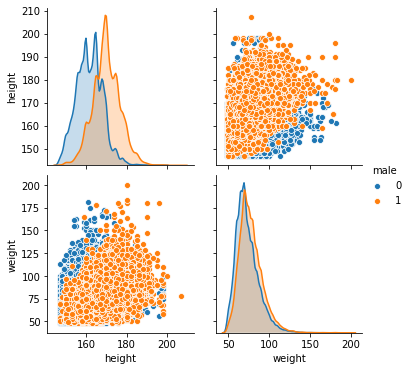

In [27]:
sns.pairplot(data=df[['height', 'weight', 'male']], hue='male')

All of the readings seem probable, now we can start looking for possible correlations that could pinpoint<br>
us in the right direction.

                  age      male    height    weight     ap_hi     ap_lo  \
age          1.000000 -0.023706 -0.085549  0.053900  0.206740  0.152593   
male        -0.023706  1.000000  0.525913  0.147933  0.058888  0.064929   
height      -0.085549  0.525913  1.000000  0.292995  0.012414  0.028066   
weight       0.053900  0.147933  0.292995  1.000000  0.266370  0.248102   
ap_hi        0.206740  0.058888  0.012414  0.266370  1.000000  0.719603   
ap_lo        0.152593  0.064929  0.028066  0.248102  0.719603  1.000000   
cholesterol  0.153280 -0.036093 -0.055706  0.144489  0.193829  0.159739   
gluc         0.099521 -0.021848 -0.023589  0.107791  0.091314  0.072303   
smoke       -0.048536  0.337061  0.196997  0.066297  0.024657  0.024174   
alco        -0.029273  0.171367  0.098933  0.066651  0.032358  0.038086   
active      -0.010149  0.006649 -0.009051 -0.015021  0.002085  0.002110   
cardio       0.236646  0.006688 -0.014530  0.178122  0.432652  0.343552   

             cholesterol

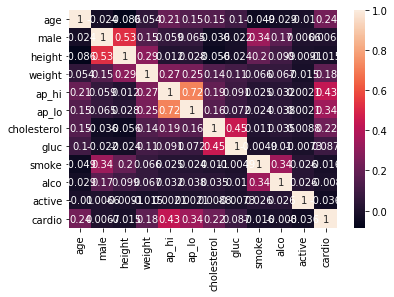

In [28]:
corrMatrix = df.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

From the first glance and the correlation matrix's cardio row, we can see that it represents the lowest<br>
correlation with persons height, his/her status to smoking, drinking and being physically active.<br>
We will confirm it with iterating over categorical values versus having or not having CDV.

For starters we need to check if only the categorical data is of int64 type, and continous of float64.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67608 entries, 0 to 69300
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          67608 non-null  float64
 1   male         67608 non-null  int64  
 2   height       67608 non-null  int64  
 3   weight       67608 non-null  float64
 4   ap_hi        67608 non-null  float64
 5   ap_lo        67608 non-null  float64
 6   cholesterol  67608 non-null  int64  
 7   gluc         67608 non-null  int64  
 8   smoke        67608 non-null  int64  
 9   alco         67608 non-null  int64  
 10  active       67608 non-null  int64  
 11  cardio       67608 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 9.2 MB


As we can see, height although being continous data, is represented as int64 so we need to change its type.

In [30]:
df['height'] = df['height'].astype(np.float64)

Now we can proceed to iterating over categorical values:

In [31]:
for x in df:
    if df[x].dtype != 'float64' and x != 'cardio':
        print('Having CVD:', x)
        print(df[[x, 'cardio']].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Having CVD: male
   male    cardio
0     0  0.497333
1     1  0.504327
---------- 

Having CVD: cholesterol
   cholesterol    cardio
0            1  0.440513
1            2  0.603595
2            3  0.763067
---------- 

Having CVD: gluc
   gluc    cardio
0     1  0.481124
1     2  0.591118
2     3  0.619472
---------- 

Having CVD: smoke
   smoke    cardio
0      0  0.502281
1      1  0.474463
---------- 

Having CVD: alco
   alco    cardio
0     0  0.500758
1     1  0.483183
---------- 

Having CVD: active
   active    cardio
0       0  0.536043
1       1  0.490965
---------- 



As we can see, according to this dataset, there is negligible correlation between sex, being prone to alcohol,<br>
being physically active and having higher chance of suffering from CVD. Therefore we should be able to exclude<br>
these features from ML model without visible penalizing its performance.<br>
After such preparation of data, we are now able to save it and pass it to our ML model.

In [32]:
df.to_csv('data_prepared.csv', index=False)

Hyperparameter optimization

In [33]:
columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active']
x = df[columns]
y = df['cardio']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.75, random_state=1)
forest = RandomForestClassifier(random_state=1)
param_dist = {'max_depth': [2, 3, 4, 5, 6 ,7, 8, 9],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(forest, cv = 3,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n',
      cv_rf.best_params_)


Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2'}


In [34]:
# forest.set_params(criterion = 'gini',
#                   max_features = 'auto',
#                   max_depth = 8,
#                   bootstrap = True)
forest.set_params(bootstrap = True,
                  criterion = 'entropy',
                  max_depth = 7, 
                  max_features = 'log2')
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
print('Random forest score: ', forest.score(x_test, y_test))
me = np.array([24,179,74,128,76,1,1,0]).reshape(1, -1)
mother = np.array([48,156,54,177,79,1,1,0]).reshape(1, -1)
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(conf_mat)
print('Predicted outcome for me: ', forest.predict(me)[0])
# Getting right probability for the case
i = 0
if forest.predict(me)[0] == 1:
    i = 1
print('Probability of prediction being right: ', forest.predict_proba(me)[0][i])
print('Predicted outcome for my mother: ', forest.predict(mother)[0])
# Getting right probability for the case
i = 0
if forest.predict(mother)[0] == 1:
    i = 1
print('Probability of prediction being right: ', forest.predict_proba(mother)[0][i], '\n')

# Get numerical feature importances
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Random forest score:  0.7335226600402319
Confusion matrix:
[[6848 1696]
 [2808 5550]]
Predicted outcome for me:  0
Probability of prediction being right:  0.8204245389045046
Predicted outcome for my mother:  1
Probability of prediction being right:  0.7727028200328989 

Variable: ap_hi                Importance: 0.48
Variable: ap_lo                Importance: 0.23
Variable: age                  Importance: 0.13
Variable: cholesterol          Importance: 0.1
Variable: weight               Importance: 0.03
Variable: height               Importance: 0.01
Variable: gluc                 Importance: 0.01
Variable: active               Importance: 0.01


[None, None, None, None, None, None, None, None]